In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [2]:
df = pd.read_csv('Unified-1.csv', low_memory = False)

In [3]:
df.isna()

,DATE,TIME,STATION,LATITUDE,LONGITUDE,ELEVATION,TEMPERATURE,RELATIVE HUMIDITY,ACTUAL VAPOR PRESSURE,DEWPOINT TEMPERATURE,WIND DIRECTION,WIND GUST,WIND SPEED,GLOBAL SOLAR RADIATION,SOLAR RADIATION/MIN,PRECIPITATION,BAROMETRIC PRESSURE
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131208,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
131209,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
131210,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
131211,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [4]:
date_obj = pd.to_datetime(df['DATE'], format ='%m/%d/%Y')
df['date']= date_obj

df['hour'] = df['TIME'].str.split(':').apply(lambda x: int(x[0]) + int(x[1]) / 60)
df.dtypes

DATE                              object
TIME                              object
STATION                           object
LATITUDE                          object
LONGITUDE                         object
ELEVATION                         object
TEMPERATURE                       object
RELATIVE HUMIDITY                 object
ACTUAL VAPOR PRESSURE            float64
DEWPOINT TEMPERATURE              object
WIND DIRECTION                   float64
WIND GUST                        float64
WIND SPEED                       float64
GLOBAL SOLAR RADIATION           float64
SOLAR RADIATION/MIN              float64
PRECIPITATION                    float64
BAROMETRIC PRESSURE              float64
date                      datetime64[ns]
hour                             float64
dtype: object

In [5]:
df['TEMPERATURE'] = df['TEMPERATURE'].str.replace('-', ' ').str.replace('+', ' ')
df['RELATIVE HUMIDITY'] = df['RELATIVE HUMIDITY'].str.replace('-', ' ').str.replace('+', ' ')
df['DEWPOINT TEMPERATURE'] = df['DEWPOINT TEMPERATURE'].str.replace('-', ' ').str.replace('+', ' ')

df[['TEMPERATURE', 'RELATIVE HUMIDITY', 'DEWPOINT TEMPERATURE']] = df[['TEMPERATURE', 'RELATIVE HUMIDITY', 'DEWPOINT TEMPERATURE']].astype(float)


In [6]:
df.fillna(value = 0, inplace = True)
df

,DATE,TIME,STATION,LATITUDE,LONGITUDE,ELEVATION,TEMPERATURE,RELATIVE HUMIDITY,ACTUAL VAPOR PRESSURE,DEWPOINT TEMPERATURE,WIND DIRECTION,WIND GUST,WIND SPEED,GLOBAL SOLAR RADIATION,SOLAR RADIATION/MIN,PRECIPITATION,BAROMETRIC PRESSURE,date,hour
0,01/01/2019,0:00,Grand Coulee Dam,47.94527 N,-118.95361 W,1320',27.13,78.57,0.39,21.35,200.1,5.92,2.00,2343.0,0.0,12.98,30.41,2019-01-01,0.0
1,01/01/2019,1:00,Grand Coulee Dam,47.94527 N,-118.95361 W,1320',27.55,76.13,0.39,21.03,253.4,5.48,2.54,2343.0,0.0,12.98,30.40,2019-01-01,1.0
2,01/01/2019,2:00,Grand Coulee Dam,47.94527 N,-118.95361 W,1320',27.20,74.20,0.37,20.08,295.2,3.51,1.87,2343.0,0.0,12.98,30.40,2019-01-01,2.0
3,01/01/2019,3:00,Grand Coulee Dam,47.94527 N,-118.95361 W,1320',27.41,77.32,0.39,21.25,260.2,4.16,2.10,2343.0,0.0,12.98,30.39,2019-01-01,3.0
4,01/01/2019,4:00,Grand Coulee Dam,47.94527 N,-118.95361 W,1320',28.04,79.24,0.41,22.44,166.1,3.95,1.22,2343.0,0.0,12.98,30.37,2019-01-01,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131208,01/01/2022,19:00,Entiat Fish Hatchery,47.69796 N,-120.32373 W,1033',12.60,82.60,0.22,8.31,197.7,0.88,0.10,5763.0,0.0,9.28,0.00,2022-01-01,19.0
131209,01/01/2022,20:00,Entiat Fish Hatchery,47.69796 N,-120.32373 W,1033',12.83,78.70,0.21,7.45,337.1,3.95,1.50,5763.0,0.0,9.29,0.00,2022-01-01,20.0
131210,01/01/2022,21:00,Entiat Fish Hatchery,47.69796 N,-120.32373 W,1033',12.73,76.28,0.21,6.68,320.5,4.16,1.91,5763.0,0.0,9.29,0.00,2022-01-01,21.0
131211,01/01/2022,22:00,Entiat Fish Hatchery,47.69796 N,-120.32373 W,1033',11.19,78.99,0.20,5.94,336.2,4.38,1.65,5763.0,0.0,9.28,0.00,2022-01-01,22.0


In [7]:
df['date_float']= df['date'].astype('int64')/10**9

In [8]:
X = df[['date_float','hour','TEMPERATURE', 'RELATIVE HUMIDITY', 'ACTUAL VAPOR PRESSURE', 'DEWPOINT TEMPERATURE', 'WIND DIRECTION', 'WIND GUST', 'WIND SPEED','SOLAR RADIATION/MIN','PRECIPITATION', 'BAROMETRIC PRESSURE']].values
y = df['GLOBAL SOLAR RADIATION'].values.reshape(-1, 1)  
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=70)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=70)


# Standardize features
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train_scaled = scaler1.fit_transform(X_train)
X_val_scaled = scaler1.transform(X_val)
X_test_scaled = scaler1.transform(X_test)
y_train_scaled = scaler2.fit_transform(y_train)
y_val_scaled = scaler2.transform(y_val)
y_test_scaled = scaler2.transform(y_test)

#print(f"{X_train.shape} {X_val.shape} :: {X_test.shape}" )

In [9]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ComplexCNNModel(nn.Module):
    def __init__(self):
        super(ComplexCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)  # Batch normalization after conv1
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)  # Batch normalization after conv2
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)  # Batch normalization after conv3

        self.fc1 = nn.Linear(128 * 1, 512)  # Input_size is adjusted be careful
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 256)  # An Additional dense layer is added with reduced units
        self.fc4 = nn.Linear(256, 1)  # Output layer with reduced units
        # Define dropout layer
        self.dropout = nn.Dropout(p=0.5)  # Adjusted dropout rate

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.bn1(F.relu(self.conv1(x)))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = self.bn2(F.relu(self.conv2(x)))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = self.bn3(F.leaky_relu(self.conv3(x)))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        
        # Flattening the output for fully connected layers with Adjusted input size
        x = x.view(-1, 128 * 1)  
        
        # Apply fully connected layers with increased depth
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  #  dropout
        x = F.relu(self.fc2(x))       
        x = self.dropout(x)  #  dropout
        x = F.leaky_relu(self.fc3(x))  # Additional dense layer
        x = self.dropout(x)  #  dropout
        x = self.fc4(x) # Output layer
        return x

model = ComplexCNNModel()
print(model)


ComplexCNNModel(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
batch_size = 80
learning_rate = 0.001

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Xavier initialization
for layer in [model.fc1, model.fc2, model.fc3, model.fc4]:
    nn.init.xavier_uniform_(layer.weight)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Using Mean Squared Error loss for regression
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01)



Epoch [1/100], Train Loss: 1.2320, Valid Loss: 0.9994
Epoch [2/100], Train Loss: 1.0246, Valid Loss: 0.9994
Epoch [3/100], Train Loss: 1.0128, Valid Loss: 0.9992
Epoch [4/100], Train Loss: 1.0058, Valid Loss: 0.9992
Epoch [5/100], Train Loss: 1.0047, Valid Loss: 0.9994
Epoch [6/100], Train Loss: 1.0029, Valid Loss: 0.9988
Epoch [7/100], Train Loss: 1.0015, Valid Loss: 0.9989
Epoch [8/100], Train Loss: 1.0009, Valid Loss: 0.9993
Epoch [9/100], Train Loss: 1.0006, Valid Loss: 0.9988
Epoch [10/100], Train Loss: 0.9995, Valid Loss: 0.9986
Epoch [11/100], Train Loss: 0.9998, Valid Loss: 0.9983
Epoch [12/100], Train Loss: 0.9993, Valid Loss: 0.9981
Epoch [13/100], Train Loss: 0.9985, Valid Loss: 0.9978
Epoch [14/100], Train Loss: 0.9984, Valid Loss: 0.9976
Epoch [15/100], Train Loss: 0.9980, Valid Loss: 0.9974
Epoch [16/100], Train Loss: 0.9978, Valid Loss: 0.9975
Epoch [17/100], Train Loss: 0.9979, Valid Loss: 0.9970
Epoch [18/100], Train Loss: 0.9977, Valid Loss: 0.9967
Epoch [19/100], Tra

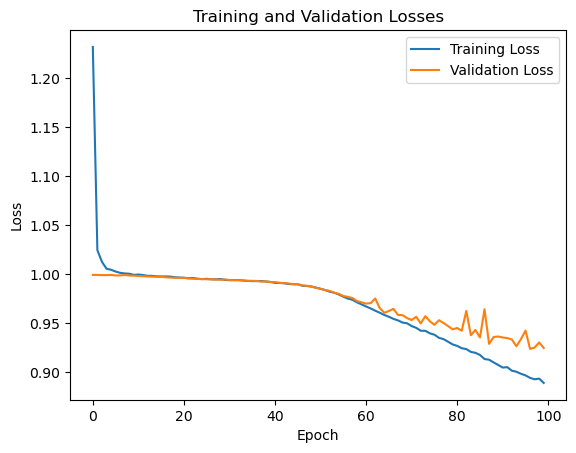

In [22]:
train_losses = []
valid_losses = []

num_epochs = 100  # Set a meaningful number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    valid_loss = 0
    
    model.train()  
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
    
    # Calculate average loss per sample for the epoch
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(val_loader.dataset)
    
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')
    
    # Append losses to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

# Evaluation 
model.eval()  
with torch.no_grad():
    train_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        train_loss += criterion(outputs, labels).item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    print(f'Train Loss: {train_loss:.4f}')

model.eval()  
with torch.no_grad():
    valid_loss = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        valid_loss += criterion(outputs, labels).item() * inputs.size(0)
    valid_loss /= len(val_loader.dataset)
    print(f'Validation Loss: {valid_loss:.4f}')

# Plotting the training and validation losses
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epoch [1/100], Train Loss: 1.1790, Valid Loss: 0.9983, Test Loss:  0.9995
Epoch [2/100], Train Loss: 1.0336, Valid Loss: 0.9976, Test Loss:  0.9988
Epoch [3/100], Train Loss: 1.0147, Valid Loss: 0.9976, Test Loss:  0.9988
Epoch [4/100], Train Loss: 1.0073, Valid Loss: 0.9971, Test Loss:  0.9984
Epoch [5/100], Train Loss: 1.0035, Valid Loss: 0.9965, Test Loss:  0.9978
Epoch [6/100], Train Loss: 1.0012, Valid Loss: 0.9959, Test Loss:  0.9973
Epoch [7/100], Train Loss: 0.9993, Valid Loss: 0.9956, Test Loss:  0.9969
Epoch [8/100], Train Loss: 0.9978, Valid Loss: 0.9952, Test Loss:  0.9965
Epoch [9/100], Train Loss: 0.9965, Valid Loss: 0.9945, Test Loss:  0.9959
Epoch [10/100], Train Loss: 0.9956, Valid Loss: 0.9942, Test Loss:  0.9956
Epoch [11/100], Train Loss: 0.9956, Valid Loss: 0.9935, Test Loss:  0.9948
Epoch [12/100], Train Loss: 0.9945, Valid Loss: 0.9931, Test Loss:  0.9945
Epoch [13/100], Train Loss: 0.9932, Valid Loss: 0.9926, Test Loss:  0.9940
Epoch [14/100], Train Loss: 0.9925

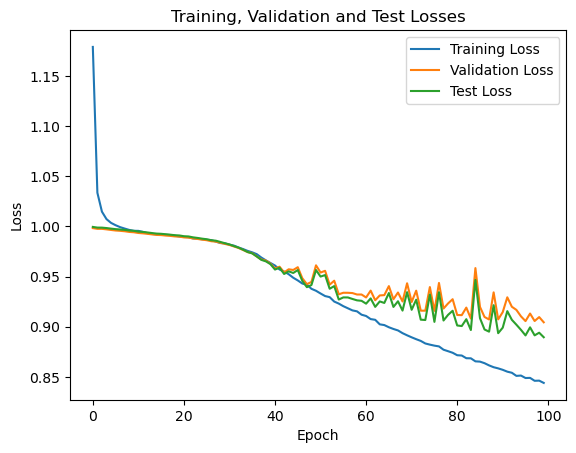

In [12]:
train_losses = []
valid_losses = []
test_losses = []

num_epochs = 100  # Set a meaningful number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    valid_loss = 0
    test_loss = 0
    
    model.train()  
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            
            
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
    
    # Calculate average loss per sample for the epoch
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(val_loader.dataset)
    test_loss /= len(test_loader.dataset)
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Test Loss: {test_loss: .4f}')
    
    # Append losses to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_losses.append(test_loss)

# Evaluation 
model.eval()  
with torch.no_grad():
    train_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        train_loss += criterion(outputs, labels).item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    print(f'Train Loss: {train_loss:.4f}')

model.eval()  
with torch.no_grad():
    valid_loss = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        valid_loss += criterion(outputs, labels).item() * inputs.size(0)
    valid_loss /= len(val_loader.dataset)
    print(f'Validation Loss: {valid_loss:.4f}')
    
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
        

# Plotting the training and validation losses
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Losses')
plt.legend()
plt.show()


In [15]:
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    

Test Loss: 0.8895


/var/folders/x7/_r8bw_1n571f46bh_8p4kw3m0000gp/T/ipykernel_88883/1998358245.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(Time_str, rotation=90)


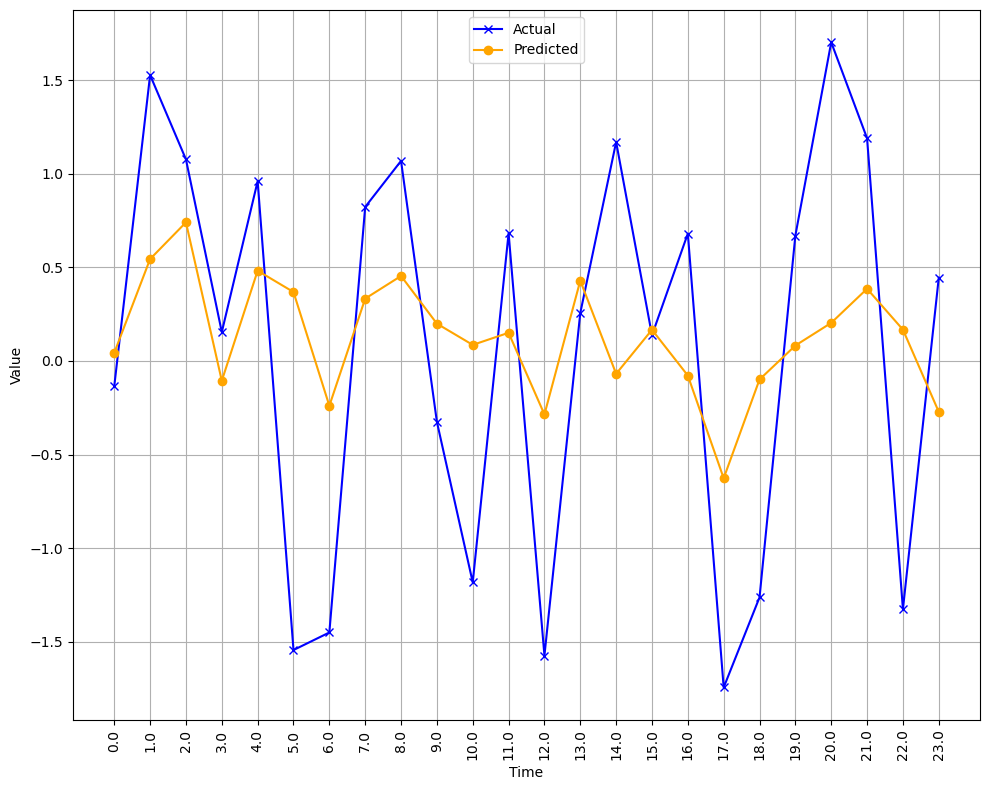

In [14]:
actual_values = []  
predicted_values = []  

Time = df['hour'][:24]
Time_str = [str(hour) for hour in Time]

for inputs, labels in test_loader:
    outputs = model(inputs)
    actual_values.extend(labels.detach().numpy())
    predicted_values.extend(outputs.detach().numpy())


fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(Time_str, actual_values[:24], color='blue',marker='x', label='Actual')
ax.plot(Time_str, predicted_values[:24], color='orange', marker='o', label='Predicted')

ax.set_xlabel('Time')
ax.set_ylabel('Value')

ax.legend(loc='upper center')

ax.set_xticklabels(Time_str, rotation=90)

ax.grid(True)

plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import r2_score

# Switch model to evaluation mode
model.eval()

# Lists to store actual and predicted values
actual_values = []
predicted_values = []

# Iterate over the validation or test loader
with torch.no_grad():
    for inputs, labels in val_loader:  # Use val_loader or test_loader
        outputs = model(inputs)
        actual_values.extend(labels.tolist())
        predicted_values.extend(outputs.tolist())

# Calculate R^2 score
r2 = r2_score(actual_values, predicted_values)
print("Val R^2 score:", r2)


from sklearn.metrics import r2_score

# Switch model to evaluation mode
model.eval()

# Lists to store actual and predicted values
actual_values = []
predicted_values = []

# Iterate over the validation or test loader
with torch.no_grad():
    for inputs, labels in test_loader:  # Use val_loader or test_loader
        outputs = model(inputs)
        actual_values.extend(labels.tolist())
        predicted_values.extend(outputs.tolist())

# Calculate R^2 score
r2 = r2_score(actual_values, predicted_values)
print("Test R^2 score:", r2)


Val R^2 score: 0.09529841809806339
Test R^2 score: 0.11160745223485136
